Natural language processing (NLP) или обработка естественного языка - это направление в машинном обучении, посвященное распознаванию, генерации и обработке устной и письменной человеческой речи.

# Основные задачи NLP

* Классификация
  * Темы и жанры;
  * Наличие/отсутстиве информации;
  * Тональность
* Кластеризация (тематическое моделирование)
* Машинный перевод
* Извлечение информации
  * Факты
  * Именованные сущности
* Информационный поиск
* Генерация текста
* Вопросно-ответные (диалоговые) системы
* Распознавание (STT) и синтез (TTS) речи

# Проблемы

* Неоднозначность
  * Лексическая неоднозначность: ключ, ручка
  * Морфологическая неоднозначность: что делают белки в клетке?
  * Синтаксическая неоднозначность: эти типы стали есть в цехе
* Неологизмы (отсутствуют в корпусах)
* Вариативность написания: Россия, Российская Федерация, РФ
* Нестандартное написание (в том числе опечатки)

# Этапы решения NLP-задач



1. Анализ предметной области и постановка задачи
2. Сбор и разметка данных
3. Обработка сырых данных - определение языка (если требуется), удаление лишних символов и тэгов, исправление опечаток
4. Токенизация и сегментация - деление последовательности символов на составные части
5. Получение модели представления текста путем использования следующих техник: стемминг, определение частей речи + лемматизация, разрешение кореференции, NER (выделение именованных сущностей), извлечение ключевых слов
6. Формирование признакового пространства. Bag of words, TF-IDF, word2vec, BERTembeddings и т.д.
7. Применение какого-либо алгоритма (не обязательно ML)
8. Оценка результатов

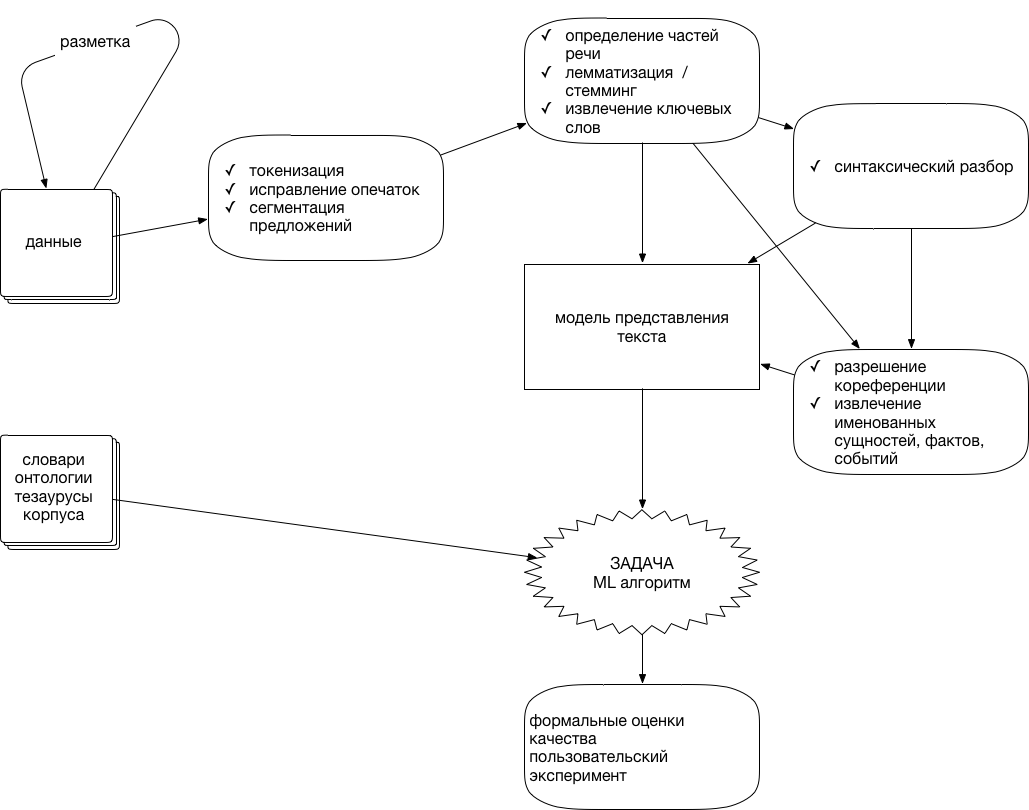

[Источник картинки](https://github.com/ancatmara/data-science-nlp/blob/master/1.%20Intro.ipynb)

Рассмотрим основные этапы решения задач на примере классической задачи фильтрации спама.

1. Анализ предметной области и постановка задачи

Мы хотим создать алгоритм, который будет принимать на вход текст и возвращать для него метку класса - 0, если текст не является спамом, и 1 в обратном случае. Решим задачу для английского языка.

2. Сбор и разметка данных

Найдем подходящий под нашу задачу датасет. Воспользуемся [поисковиком](https://datasetsearch.research.google.com/).

Если готового датасета нет, можно собрать его и разметить самостоятельно. Для разметки можно использовать [толоку](https://toloka.ai/tolokers/ru/).

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

spam_df = pd.read_csv('/content/drive/MyDrive/Work/NLP 23 24/data/spam.csv', usecols=['v1', 'v2'], encoding="ISO-8859-1")
spam_df.columns = ['label', 'text']
spam_df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
spam_df.isna().sum()

label    0
text     0
dtype: int64

In [ ]:
spam_df.label.value_counts()

ham     4825
spam     747
Name: label, dtype: int64

3. Обработка сырых данных

In [ ]:
spam_df['text'] = spam_df.text.apply(lambda text: text.lower())

4. Токенизация и сегментация

In [ ]:
spam_df['text'] = spam_df.text.apply(lambda text: text.split())  # самая простая токенизация - разбиение по пробелам

5. Получение модели представления текста

Воспользуемся техникой стемминга, то есть обрезки слова до, условно, его корня. Стемминг работает быстро и часто дает неплохие результаты для английского языка.

Также создадим микро-словарь стоп-слов. Стоп-слова - это слова, которые можно безболезненно удалить, потому что они не несут смысловой нагрузки.

In [ ]:
import nltk
from nltk.stem.snowball import SnowballStemmer

snow_stemmer = SnowballStemmer(language='english')
stopwords = ['a', 'the']
spam_df['text'] = spam_df.text.apply(lambda text: ' '.join([snow_stemmer.stem(word) for word in text if word not in stopwords]))

6. Формирование признакового пространства

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

vectorizer = CountVectorizer()  # просто посчитаем, сколько раз каждое слово из словаря встречается в текстах
X = vectorizer.fit_transform(spam_df["text"])
X_train, X_test, y_train, y_test = train_test_split(X, spam_df["label"], test_size=0.2, random_state=42, stratify=spam_df["label"])

In [ ]:
X

<5572x8182 sparse matrix of type '<class 'numpy.int64'>'
	with 72528 stored elements in Compressed Sparse Row format>

7. Применение алгоритма

In [ ]:
from sklearn.naive_bayes import MultinomialNB

classifier = MultinomialNB()
classifier.fit(X_train, y_train)

MultinomialNB()

8. Оценка результата

In [ ]:
y_pred = classifier.predict(X_test)

classification_rep = classification_report(y_test, y_pred)
print(f"Classification Report:\n{classification_rep}")

Classification Report:
              precision    recall  f1-score   support

         ham       0.99      0.99      0.99       966
        spam       0.93      0.95      0.94       149

    accuracy                           0.98      1115
   macro avg       0.96      0.97      0.96      1115
weighted avg       0.98      0.98      0.98      1115



Выглядит неплохо.

Посмотрим, где модель ошибается.

In [ ]:
spam_df.iloc[y_test[y_test != y_pred].index]

,label,text
5,spam,freemsg hey there darl it been 3 week now and ...
855,spam,talk sexy!! make new friend or fall in love in...
3358,spam,sorri i miss your call let talk when you have ...
3715,ham,network technic support associate.
1986,ham,s..antha num corrct dane
2635,ham,tiwari to rcb.battl between bang and kochi.
2569,ham,ultim tor motiv tui achiev korli.
1268,spam,can u get 2 phone now? i wanna chat 2 set up m...
3888,ham,unlimit texts. limit minutes.
1939,spam,more peopl are dog in your area now. call 0909...


С развитием нейронных сетей можно вполне справедливо задасться вопросом: "А зачем нам всё это учить, если есть преусловутый ChatGPT и LLM?" Ответ примерно такой же, как ответ на вопрос, зачем изучать АиСД, когда всё уже написано в специальных библиотках - чтобы понимать, как оно работает и почему может сломаться.

Кроме того, многие компании в силу особенностей инфраструктуры не готовы внедрять ChatGPT в свои сервисы, в частности это касается гос. структур. Запросы на "сделайте нам локальный ChatGPT" на хакатонах в последнее время очень и очень часты.

Ну и последнее, ChatGPT и LLM требуют больших мощностей для работы. Нужно соблюдать баланс качества и трудозатрат. Если от вас в задаче хотят худо-бедно работающий классификатор, вероятно нет смысла страдать с трансформерами (предобученными моделями, основанными на нейронных сетях), возможно Наивный Байес справится не хуже?..

# Полезные ссылки

* [Курс по NLP от Стэнфорда](https://web.stanford.edu/class/cs224n/)

* [Курс по обработке естественного языка от МГУ](https://www.youtube.com/watch?app=desktop&v=QnuLkiXKjc8&list=PL5cBzMoPJgCXFdSvWaunOy4cILirW1lMD&index=1&ab_channel=%D0%98%D0%A1%D0%9F%D0%A0%D0%90%D0%9D)

* [Курс для студентов направления Digital Humanities](https://github.com/dhhse/dhcourse/tree/gh-pages)

* [Курс Елены Войты](https://lena-voita.github.io/nlp_course.html#main_page_content)